This is a live demo of [Characterizing Racial Disparity in Cancers by Predicting Candidate Biomarkers project](https://docs.google.com/presentation/d/1sQoODp2f_RClGuIPsUeYpZje6RdVMNPh/edit#slide=id.p1)

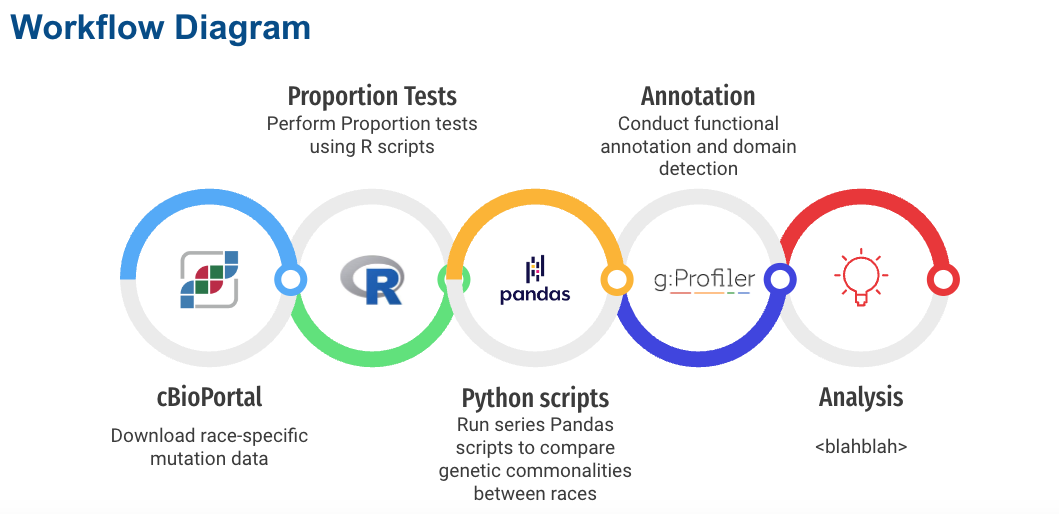

** Attribute to  [Slidesgo](https://slidesgo.com/?utm_source=Slidesgo_template&utm_medium=referral-link&utm_campaign=SG_Credits&utm_content=slidesgo) and [Freepik](https://www.freepik.com/) in your final presentation and include links to both websites.

# Data Prep: Mount The shared Folder on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# shared folder added with shortcut as folder "Cancers"
root_drive_path = '/content/drive/MyDrive/Cancers/'

In [ ]:
from enum import unique
import pandas as pd
import re
import numpy as np

# Step 1: Significant P Values

1.   Calculate the frequency of mutated genes in each race for TCGA cancers
2.   Perform proportion test for the frequency of mutation
3.   Select genes with significant p-values from proportion test

In [ ]:

def read_race_gene_file(cancer,race):
    try:
        file_name = root_drive_path + 'Judy_MutationRate_Files/' + cancer + '_' + race + '_Vs_White.csv'
        data = pd.read_csv(file_name, index_col = 0)

        # only keep the significant (p_value < 0.05) genes
        data = data[data['p value'] < 0.05].rename(columns = {"p value": "p value " + race})

        mutationData = pd.read_csv(root_drive_path + 'TCGA_mutprop_cancer_race_info.csv', index_col = 0)
        # prefix of column name with cancer and race
        colName = 'TCGA-' + cancer + "(" + race

        data_header = mutationData.columns
        for col in data_header:
            try:

                if col.startswith(colName):
                    # keep only gene_name and the cancer+ race col
                    mutationDataSubset = mutationData[['gene_name', col]]
                    # merge two dataframes based on gene name, keeping only significant genes
                    inner_merged = pd.merge(data, mutationDataSubset, left_on = ["Gene"], right_on = ["gene_name"])
                    inner_merged = inner_merged[['Gene', 'p value ' + race, col]]
                    # sort the dataframe with descending order of p values
                    inner_merged = inner_merged.sort_values([col,"Gene"], ascending = [False,True])
                    inner_merged = inner_merged.rename(columns = {col: "mutation rates"})
                    inner_merged.to_csv(root_drive_path + '/2023_summer/Daniel_step1_SignificantP_results_colab/' + cancer + '_' + race + '_genes.csv', index = False)
                    return

            except KeyError:
                pass

    except FileNotFoundError:
        pass

    # return data

cancers = input("What are the cancers? ALL for all Cancer types or Cancer names separated by comma. ")

if cancers == "ALL":
    data = pd.read_csv(root_drive_path + 'TCGA_mutprop_cancer_race_info.csv')
    data_header = data.columns
    cancers = set()
    for col_header in data_header:
        try:
            cancer_name = re.search("TCGA-(.+?)\(", col_header).group(1)
            cancers.add(cancer_name)
        except AttributeError:
            pass
else:
    cancers = cancers.split(',')

for cancer in cancers:
    # read Asian gene file
    read_race_gene_file(cancer, "Asian")

    # read Black gene file
    read_race_gene_file(cancer, "Black")




# Step 2A: Find the longest common sequence

Calculate the longest common list of genes in sorted order based on their p-value for both Asian and Black files

We are looking for the following Cancer types: UCS,THCA,PRAD,LIHC,KIRP,KIRC,ESCA,BRCA,BLCA


In [ ]:
from enum import unique
import pandas as pd
import re
import numpy as np
# lcs section of code from https://www.programiz.com/dsa/longest-common-subsequence

# dynamic programming function to find longest common sequence
def lcs(L1, L2, m, n):
    L = [[0 for x in range(n+1)] for x in range(m+1)]

    # Building the matrix in bottom-up way
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif L1[i-1] == L2[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])

    index = L[m][n]

    lcs_algo = [""] * (index+1)
    lcs_algo[index] = ""

    i = m
    j = n
    while i > 0 and j > 0:

        if L1[i-1] == L2[j-1]:
            lcs_algo[index-1] = L1[i-1]
            i -= 1
            j -= 1
            index -= 1

        elif L[i-1][j] > L[i][j-1]:
            i -= 1
        else:
            j -= 1

    # Printing the sub sequences
    return lcs_algo

cancers = input("What are the cancers? You can use 'UCS,THCA,PRAD,LIHC,KIRP,KIRC,ESCA,BRCA,BLCA' ")
for cancer in cancers.split(','):
  print(cancer)
  try:
      asian_data = pd.read_csv(root_drive_path + 'Daniel_step1_SignificantP_results_colab/' + cancer + '_Asian_genes.csv')
      black_data = pd.read_csv(root_drive_path + 'Daniel_step1_SignificantP_results_colab/' + cancer + '_Black_genes.csv')
      asian_data_gene = asian_data['Gene'].values.tolist()
      black_data_gene = black_data['Gene'].values.tolist()
      lcs_genes = lcs(asian_data_gene, black_data_gene, len(asian_data_gene), len(black_data_gene))

      lcs_column_names = ['gene',
                              'p_value_asian',
                              'mutation_asian',
                              'p_value_black',
                              'mutation_black']

      lcs_df = pd.DataFrame(columns = lcs_column_names)

      for gene in lcs_genes:
          if gene != '':
              asian_gene_data = asian_data.loc[asian_data['Gene'] == gene]
              black_gene_data = black_data.loc[black_data['Gene'] == gene]

              new_df = pd.DataFrame({'gene' : gene,
              'p_value_asian' : asian_gene_data.iloc[0]['p value Asian'],
              'mutation_asian' : asian_gene_data.iloc[0]['mutation rates'],
              'p_value_black' : black_gene_data.iloc[0]['p value Black'],
              'mutation_black' : black_gene_data.iloc[0]['mutation rates']}, index = [0])

              lcs_df = pd.concat([lcs_df,new_df], ignore_index = True, axis = 0)

      lcs_df.to_csv(root_drive_path + '/2023_summer/Daniel_step2a_LCS_results_colab/' + cancer + '_lcs.csv', index = False)
  except FileNotFoundError:
      print("File not found")

# Step 2B: find the common genes

Calculate common genes between the Asian and Black race files

We are looking for the following Cancers: UCS,THCA,PRAD,LIHC,KIRP,KIRC,ESCA,BRCA,BLCA


In [ ]:
from enum import unique
import pandas as pd
import re
import numpy as np


cancers = input("What are the cancers? You can use 'UCS,THCA,PRAD,LIHC,KIRP,KIRC,ESCA,BRCA,BLCA' ")
cancers = cancers.split(",")

column_names = ['cancer',
                'unique_asian_genes',
                'common_genes',
                'unique_black_genes']

gene_df = pd.DataFrame(columns = column_names)

for cancer in cancers:
    print(cancer)
    asian_data = pd.read_csv(root_drive_path + 'Daniel_step1_SignificantP_results_colab/' + cancer + '_Asian_genes.csv')
    black_data = pd.read_csv(root_drive_path + 'Daniel_step1_SignificantP_results_colab/' + cancer + '_Black_genes.csv')
    common_data = asian_data.merge(black_data, on = ['Gene'])
    common_genes = common_data['Gene'].tolist()
    unique_asian_genes = list(set(asian_data['Gene'].tolist()) - set(common_genes))
    unique_black_genes = list(set(black_data['Gene'].tolist()) - set(common_genes))

    gene_new_df = pd.DataFrame({'cancer': cancer,
                                'unique_asian_genes' : ', '.join(unique_asian_genes),
                                'common_genes' : ', '.join(common_genes),
                                'unique_black_genes' : ', '.join(unique_black_genes)},
                                index = [0])

    gene_df = pd.concat([gene_df,gene_new_df], ignore_index = True, axis = 0)

gene_df.to_csv(root_drive_path + '/2023_summer/Daniel_step2b_common_genes_colab/gene_list.csv', index = False)

#Step 3: Longest protein sequence


1.   Extract protein sequences from Ensembl of genes found in Step 2.1.
2.   Take longest protein sequence for each gene within file from Step 3.1.


In [ ]:
import pandas as pd

for cancer in ['UCS','THCA','PRAD','LIHC','KIRP','KIRC','ESCA','BRCA','BLCA']:
    for race in ['Asian','Black']:
        geneDict = {}
        tempSequence = ""
        geneList = []
        with open(root_drive_path + 'Judy_Step3a_EnsemblProteinSequences_Files/' + cancer + '_unique' + race + '.txt') as protein_file:
            for line in protein_file:
                if line[0] == ">":
                    gene = line.split("|")[4].replace("\n","")
                    geneDict[gene] = "";
        with open(root_drive_path + 'Judy_Step3a_EnsemblProteinSequences_Files/' + cancer + '_unique' + race + '.txt') as protein_file:
            for line in protein_file:
                if line[0] == ">":
                    gene = line.split("|")[4].replace("\n","")
                    if len(geneList) > 0:
                        lastGene = geneList[len(geneList)-1]
                        if len(tempSequence.replace("\n","").replace("*","").replace("\n","")) > len(geneDict[lastGene]):
                            geneDict[lastGene] = tempSequence.replace("\n","").replace("*","")

                            #print(lastGene)

                        else:
                            pass
                    else:
                        pass
                    geneList.append(gene)
                    tempSequence = ""
                else:
                    tempSequence += line;
        with open(root_drive_path + '/2023_summer/Daniel_Step3b_longest_protein_sequence_colab/' + cancer + '_longest_protein_sequences_' + race + '.txt', 'w') as f:
            for gene in geneDict:
                f.write('>' + gene + '\n')
                for string in [geneDict[gene][i:i+64] for i in range(0, len(geneDict[gene]), 64)]:
                    f.write(string + '\n')


# Step 4: Super family



1.   Perform CDSearch to identify superfamilies for each gene
2.   Identify common superfamilies for each race in selected cancers



In [ ]:
from enum import unique
from operator import itemgetter
import pandas as pd
import re
import numpy as np
import itertools as it
import csv

for cancer in ['UCS','THCA','PRAD','LIHC','KIRP','KIRC','ESCA','BRCA','BLCA']:
    # iterate for different races
    for race in ['Asian','Black']:
        geneSuperfamilyDict = {}
        # initialization: for each the superfamily, set gene count equal to 0
        with open(root_drive_path + 'Judy_Step4a_CDSearch_Files/' + cancer + '_' + race + '.txt') as superfamily_file:
            for line in superfamily_file:
                if line[:2] == "Q#":
                    superfamily = line.split()[9]
                    geneSuperfamilyDict[superfamily] = 0
        # read the file again and calculate the superfamily gene count numbers
        with open(root_drive_path + 'Judy_Step4a_CDSearch_Files/' + cancer + "_" + race + ".txt") as superfamily_file:
            for line in superfamily_file:
                if line[:2] == "Q#":
                    superFamily = line.split()[9]
                    geneSuperfamilyDict[superFamily] += 1

        # sort the superfamily dictionary with descending order of gene count numbers
        sorted_dict = sorted(geneSuperfamilyDict.items(), key=lambda x:x[1], reverse = True)

        # output the superfamily and count of genes
        fields = ['Superfamily', 'Count of Genes']
        rows = sorted_dict
        with open(root_drive_path + '/2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race+ '_count_of_genes_in_superfamily.csv', 'w') as f:
            write = csv.writer(f)
            write.writerow(fields)
            write.writerows(rows)

In [ ]:
from enum import unique
from operator import itemgetter
import pandas as pd
import re
import numpy as np
import itertools as it
import csv

for cancer in ['UCS','THCA','PRAD','LIHC','KIRP','KIRC','ESCA','BRCA','BLCA']:
    # iterate for different races
    for race in ['Asian','Black']:
        geneSuperfamilyDict = {}
        # initialization: for each the superfamily, set gene count equal to 0
        with open(root_drive_path + 'Judy_Step4a_CDSearch_Files/' + cancer + '_' + race + '.txt') as superfamily_file:
            for line in superfamily_file:
                if line[:2] == "Q#":
                    superfamily = line.split()[9]
                    geneSuperfamilyDict[superfamily] = {}
        # read the file again and calculate the superfamily gene count numbers
        with open(root_drive_path + 'Judy_Step4a_CDSearch_Files/' + cancer + "_" + race + ".txt") as superfamily_file:
            for line in superfamily_file:
                if line[:2] == "Q#":
                    superFamily = line.split()[9]
                    gene = line.split()[2][1:]
                    if gene in geneSuperfamilyDict[superFamily]:
                      geneSuperfamilyDict[superFamily][gene] += 1
                    else:
                      geneSuperfamilyDict[superFamily][gene] = 1

        # output the superfamily and count of genes
        fields = ['Superfamily', 'Count of Different Genes', 'Genes']

        rows = geneSuperfamilyDict
        print(geneSuperfamilyDict)
        with open(root_drive_path + '/2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race+ '_genes_in_superfamily.csv', 'w') as f:
            file = csv.writer(f)
            file.writerow(fields)
            for superfamily in geneSuperfamilyDict:
              file.writerow([superfamily, len(geneSuperfamilyDict.get(superfamily)), geneSuperfamilyDict.get(superfamily)])

        df = pd.read_csv(root_drive_path + '/2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race+ '_genes_in_superfamily.csv')
        df.sort_values(["Count of Different Genes"],
                    axis=0,
                    ascending=[False],
                    inplace=True)
        df.to_csv(root_drive_path + '/2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race+ '_genes_in_superfamily.csv', index=False)


In [ ]:
!pip install Bio
!pip install unipressed

In [ ]:
from Bio import ExPASy
from Bio import SwissProt
from unipressed import IdMappingClient
import time

def get_uniprot_accession(gene_name):
  request = IdMappingClient.submit(
  source="GeneCards", dest="UniProtKB", ids={gene_name})
  time.sleep(1.0)
  return list(request.each_result())

import requests

def get_pdb_id_from_uniprot(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.xml"
    response = requests.get(url)

    if response.status_code == 200:
        xml_content = response.text

        # Extract all PDB IDs from the XML content
        pdb_ids = []
        start_tag = "<dbReference type=\"PDB\" id=\""
        end_tag = "\""
        start_index = xml_content.find(start_tag)

        while start_index != -1:
            end_index = xml_content.find(end_tag, start_index + len(start_tag))
            pdb_id = xml_content[start_index + len(start_tag):end_index]
            pdb_ids.append(pdb_id)
            start_index = xml_content.find(start_tag, end_index)

        return pdb_ids

    else:
        print("Error: Unable to retrieve data from UniProt.")
        return []

# Example usage: searching for TTN
cancer = input("What is the cancer name? (All uppercase) ")
race = input("Choose race: Black or Asian? ")
superfamily = input("What is the superfamily name? ")

with open(root_drive_path + '/2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race+ '_genes_in_superfamily.csv') as file:
  for line in file:
    items = line.split(',', 1)
    if items[0] == superfamily:
      gene_dict = eval(items[1])
      gene_dict = eval(gene_dict)
      print(gene_dict)
      for key, value in gene_dict.items():
        gene = key
        print(gene)
        accession = get_uniprot_accession(gene)
        print(accession)
        # Example usage
        uniprot_id = accession[0].get('to')  # Replace with your UniProt ID of interest
        pdb_id = get_pdb_id_from_uniprot(uniprot_id)

        if pdb_id:
            print(f'Count of PDB ID: {len(pdb_id)} PDB ID: {pdb_id} for Uniprot ID: {uniprot_id}')
        else:
            print(f'No PDB ID found for Uniprot ID: {uniprot_id}.')

In [ ]:
# preparing new csv file for plotting superfamily plot
output_df = pd.DataFrame({'cancer_name': pd.Series(dtype='str'),
                   'race': pd.Series(dtype='str'),
                   'super_family': pd.Series(dtype='str'),
                   'order_number': pd.Series(dtype='int'),
                   'num_different_genes': pd.Series(dtype='int')})

for cancer in ['UCS','THCA','PRAD','LIHC','KIRP','KIRC','ESCA','BRCA','BLCA']:
    # iterate for different races
    for race in ['Asian','Black']:
      super_family_df = pd.read_csv(root_drive_path + '2023_summer/Daniel_step4b_superfamily_results_colab/' + cancer + '_' + race + '_genes_in_superfamily.csv')
      #get the first two rows with highest gene counts
      super_family_df_sorted = super_family_df.sort_values(['Count of Different Genes'], ascending=[False])
      for order_number in [0,1]:
        super_family_df_sorted_row = super_family_df_sorted.iloc[order_number]
        #insert row into output_df
        # Insert row to the dataframe using DataFrame.append()
        new_row = {'cancer_name': cancer,
                   'race': race,
                   'super_family': super_family_df_sorted_row['Superfamily'],
                   'order_number': order_number + 1,
                   'num_different_genes': super_family_df_sorted_row['Count of Different Genes']
                  }
        new_df = pd.DataFrame(new_row, index=[0])
        output_df = pd.concat([output_df, new_df], ignore_index=True)

file_name = root_drive_path + '2023_summer/Daniel_step4b_superfamily_results_colab/superfamily_all.csv'
print(file_name)
output_df.to_csv(file_name, index=False)

In [ ]:

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import os
import seaborn as sns

df = output_df.copy()

# Group the data by 'cancer_name', 'race', and 'order_number', and calculate the sum of 'num_different_genes'
grouped_df = df.groupby(['cancer_name', 'race', 'order_number', 'super_family'])['num_different_genes'].sum().reset_index()

# Pivot the table to prepare it for the stacked bar chart
pivoted_df = grouped_df.pivot_table(index=['cancer_name', 'race'], columns='order_number', values='num_different_genes', fill_value=0).reset_index()

# Create the grouped stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4

bar_positions = range(len(pivoted_df))

# Stacked bars for order_number 1
bars_order1 = ax.bar(bar_positions, pivoted_df[1], width, label='Superfamily 1')

# Stacked bars for order_number 2
bars_order2 = ax.bar(bar_positions, pivoted_df[2], width, bottom=pivoted_df[1], label='Superfamily 2')

# Set the x-ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(pivoted_df.apply(lambda x: f"{x['cancer_name']} - {x['race']}", axis=1), rotation=45, ha='right')

# Set the y-axis label
ax.set_ylabel('num_different_genes')

# Set the title and legend
ax.set_title('Grouped Stacked Bar Chart')
ax.legend()

plt.tight_layout()
plt.show()